In [1]:
import numpy as np
from os import sys, path, environ
from os import sep, mkdir, walk
from os import chdir, environ, getcwd
import os as os
import sys
import string, random
from shutil import copy, copytree
#
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.tri import Triangulation
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.ticker as ticker
#
import netCDF4 as nc
from ot_chaos import *
import openturns as ot
import openturns.viewer as viewer
import scipy as scipy
#
colors=['#002d74', '#e85113', '#1fa12e', '#c9d200', '#f49e00', '#006ab3', '#3381ff', '#f2855a', '#54de64']
markers=['o','x','P','^']
image_folder = "figures_TORQUE"

### Read the input timeseries from netcdf, and plot the sample

In [2]:
"""
The nc file is created using the notebook called "sample_uncertain_inputs.ipync"
"""
nc_file = nc.Dataset("windio_toy/plant_energy_resource/Stochastic_atHubHeight.nc")
nc_file_var_names = [key for key in nc_file.variables.keys()] 
nc_file_var_dimensions = nc_file.variables[nc_file_var_names[2]].dimensions
nc_file_var_shape = nc_file.variables[nc_file_var_names[2]].shape
print("Variables are : ", nc_file_var_names) # get all variable names
print("Dimensions of variable "+nc_file_var_names[2]+" are : ", nc_file_var_dimensions) #get dimensions of var 1
print("Shape of variable "+nc_file_var_names[2]+" is : ", nc_file_var_shape) #get shape of var 1

#
nvar = 3
MC_sample = np.zeros((len(nc_file.variables["time"]),nvar))

#hub height timeseries
MC_sample[:,0] = nc_file.variables["direction"][:]
MC_sample[:,1] = nc_file.variables["speed"][:]
MC_sample[:,2] = nc_file.variables["z0"][:]

##profile timeseries 
#z_hub = 119.0
#for j in range(len(nc_file.variables["time"])):
#    MC_sample[j,0] = np.interp(z_hub, nc_file.variables["z"][:], nc_file.variables["direction"][j,:])
#    MC_sample[j,1] = np.interp(z_hub, nc_file.variables["z"][:], nc_file.variables["speed"][j,:])
#MC_sample[:,2] = nc_file.variables["z0"][:]

uq_varnames = ["direction", "speed","z0"]
uq_varnames_plot  = ["direction", "speed","$z_0$"]
uq_var_marginals = ["normal", "normal", "uniform"]
#uq_var_marginals = ["kernel", "kernel", "kernel"]
uq_var_units = ["$[^\circ]$", "$[m/s]$", "$[m]$"]

Variables are :  ['time', 'direction', 'speed', 'z0', 'TI', 'ustar']
Dimensions of variable speed are :  ('time',)
Shape of variable speed is :  (1000,)


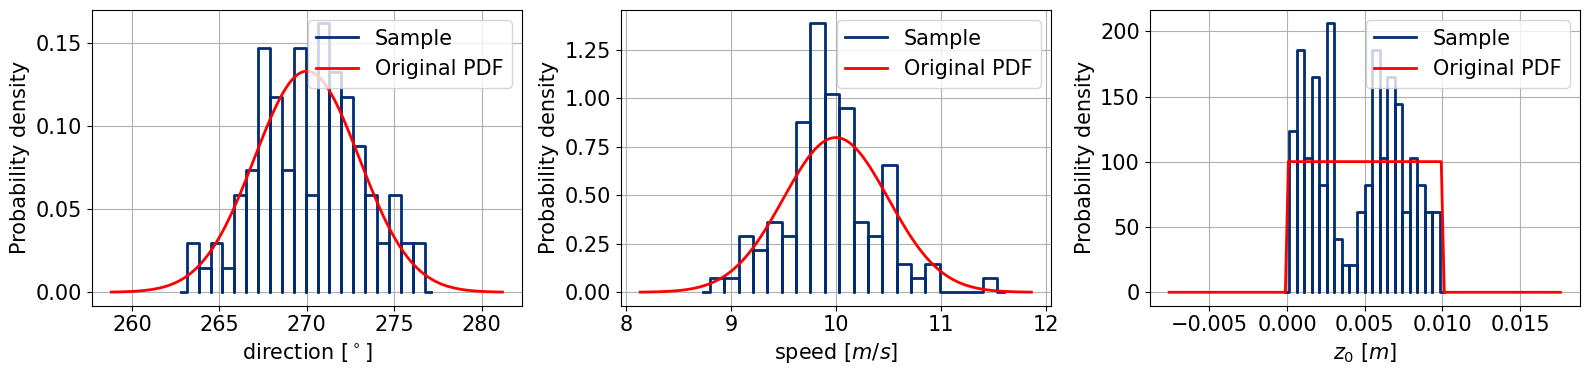

In [3]:
# plot and compare to histogram
#Define uncertain variables and PDF parameters
uq_var_number = len(uq_varnames)
mean_dir = 270.0 ; std_dir = 3.0
mean_vel = 10.0 ; std_vel = 0.05*mean_vel
min_z0 =  1e-5 ; max_z0 =  1e-2
ot_collection = ot.DistributionCollection(uq_var_number)
ot_collection_description = ot.Description(uq_var_number)
ot_collection[0] = ot.Normal(mean_dir,std_dir) #wind_dir dir_hub
ot_collection[1] = ot.Normal(mean_vel,std_vel) #wind_velocity u_hub
ot_collection[2] = ot.Uniform(min_z0,max_z0) #roughness_height z0
#
MC_sample_size = 100
histograms = [] 
graphs = []
for j in range(MC_sample.shape[1]):
    sample = ot.Sample([[i] for i in MC_sample[:MC_sample_size,j]])
    histograms.append(ot.HistogramFactory().buildAsHistogram(sample, 20))
    graphs.append(histograms[j].drawPDF())
    graphs[j].setColors(colors)
    graphs[j].setXTitle(uq_varnames_plot[j] + " "+uq_var_units[j])
    graphs[j].setYTitle("Probability density")
    #
    graphs[j].add(ot_collection[j].drawPDF())
    graphs[j].setLegends(["Sample", "Original PDF"])#[uq_varnames[j]])
    graphs[j].setTitle("")
#
fig = plt.figure(figsize=(16, 4))
axs = []
for j in range(MC_sample.shape[1]):
    axs.append(fig.add_subplot(1, MC_sample.shape[1], j+1))
    _ = viewer.View(graphs[j], figure=fig, axes=[axs[j]])
    axs[j].legend(loc="upper right", fontsize=15)
    axs[j].tick_params(axis='both', which='major', labelsize=15)
    axs[j].xaxis.label.set_size(15)
    axs[j].yaxis.label.set_size(15)
    

plt.tight_layout()
plt.savefig(image_folder + sep + "MC_sample")
plt.show()
plt.clf()
plt.close()

### Read the results from the different tools

In [4]:
#code_saturne
#code_saturne_power_table  = np.genfromtxt("flow_tools_results/code_saturne_results/windio_toy/MC_hub_timeseries_power_cpstar_code_saturne.csv", delimiter=',', skip_header=1)[:,1:]
#code_saturne_power_table_isol  = np.genfromtxt("flow_tools_results/code_saturne_results/windio_toy/MC_hub_timeseries_isol_power_cpstar_code_saturne.csv", delimiter=',', skip_header=1)[:,1:][:,0]
#
code_saturne_deduced_freestream_isol  = np.genfromtxt("flow_tools_results/code_saturne_results/windio_toy/MC_hub_timeseries_isol_FreeStreamVelocity_code_saturne.csv", delimiter=',', skip_header=1)[:,1]
#code_saturne_udisk_isol  = np.genfromtxt("flow_tools_results/code_saturne_results/windio_toy/MC_hub_timeseries_isol_DiskVelocity_code_saturne.csv", delimiter=',', skip_header=1)[:,1]
#code_saturne_uhub_isol  = np.genfromtxt("flow_tools_results/code_saturne_results/windio_toy/MC_hub_timeseries_isol_HubHeightVelocity_code_saturne.csv", delimiter=',', skip_header=1)[:,1]
#
code_saturne_deduced_freestream  = np.genfromtxt("flow_tools_results/code_saturne_results/windio_toy/MC_hub_timeseries_FreeStreamVelocity_code_saturne.csv", delimiter=',', skip_header=1)[:,1:]
#code_saturne_udisk  = np.genfromtxt("flow_tools_results/code_saturne_results/windio_toy/MC_hub_timeseries_DiskVelocity_code_saturne.csv", delimiter=',', skip_header=1)[:,1:]
#code_saturne_uhub  = np.genfromtxt("flow_tools_results/code_saturne_results/windio_toy/MC_hub_timeseries_HubHeightVelocity_code_saturne.csv", delimiter=',', skip_header=1)[:,1:]
#
speeds = [4.,5.,6.,7.,8.,9.,10.,11.,12.,13.,14.,15.,16.,17.,18.,19.,20.,21.,22.,23.,24.,25.]
powers = [263388., 751154., 1440738., 2355734., 3506858., 4993092., 6849310., 9116402., 10000754., 10009590., 10000942., 10042678., 10003480., 10001600., 10001506., 10013632., 10007428., 10005360., 10002728., 10001130., 10004984., 9997558.]
power_interpolator = scipy.interpolate.interp1d(speeds,powers)
#
code_saturne_power_table_isol = power_interpolator(code_saturne_deduced_freestream_isol)
code_saturne_power_table = np.zeros((code_saturne_deduced_freestream.shape))
for j in range(code_saturne_deduced_freestream.shape[1]):
    code_saturne_power_table[:,j] = power_interpolator(code_saturne_deduced_freestream[:,j])
#
number_of_turbines = code_saturne_power_table.shape[1]

#pywake
import xarray as xr
pywake_power_data = xr.load_dataset('pywake_hh_results/pyWake_NoBlockage_eff/PowerTable.nc')
pywake_power_table = np.zeros((MC_sample_size, number_of_turbines))
for j in range(number_of_turbines):
    pywake_power_table[:,j] = pywake_power_data['Power'].sel(wt=j).values[:MC_sample_size]

pywake_power_data_isol = xr.load_dataset('pywake_hh_results/oneTurbineNoBlockage_eff/PowerTable.nc')
pywake_power_table_isol = pywake_power_data['Power'].sel(wt=0).values[:MC_sample_size]

#foxes
foxes_power_table = np.genfromtxt("foxes_results/windio_toy/power_windio_toy_foxes_B.csv", delimiter=',', skip_header=1)[:,1:]
foxes_power_table_isol = np.genfromtxt("foxes_results/windio_toy/power_windio_toy_foxes_B.csv", delimiter=',', skip_header=1)[:,1]

#wayves
wayves_power_table = np.zeros((MC_sample_size, number_of_turbines))

### Power distributions with the different tools

##### with openturns

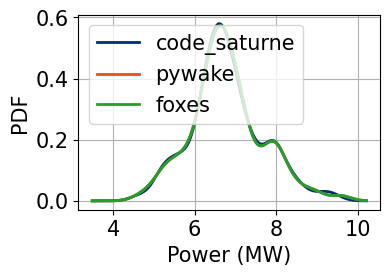

In [5]:
# read data

#power_histograms = []
#
power_graphs = []
kernel = ot.KernelSmoothing(ot.Normal())

code_saturne_power_sample = ot.Sample([[i/10**6] for i in code_saturne_power_table_isol])
pywake_power_sample = ot.Sample([[i/10**6] for i in pywake_power_table_isol])
foxes_power_sample = ot.Sample([[i/10**6] for i in foxes_power_table_isol])
#wayves_power_sample = ot.Sample([[i/10**6] for i in wayves_power_table_isol])
    
#plot and compare empirical distributions
code_saturne_power_KDE = kernel.build(code_saturne_power_sample)
pywake_power_KDE = kernel.build(pywake_power_sample)
foxes_power_KDE = kernel.build(foxes_power_sample)
#wayves_power_KDE.append(kernel.build(wayves_power_sample))    
    
#
power_graphs = code_saturne_power_KDE.drawPDF()
power_graphs.add(pywake_power_KDE.drawPDF())
power_graphs.add(foxes_power_KDE.drawPDF())
#power_graphs.add(wayves_power_KDE.drawPDF())
#
legend=["code_saturne", "pywake", "foxes"]
power_graphs.setColors(colors)
power_graphs.setXTitle("Power (MW)")
power_graphs.setYTitle("PDF")
power_graphs.setTitle("")
power_graphs.setLegends(legend)#, "wayves"])

fig = plt.figure(figsize=(4, 3))
axs = []
axs.append(fig.add_subplot(1, 1, 1))
_ = viewer.View(power_graphs, figure=fig, axes=[axs[0]])
axs[0].legend(loc="upper left", ncol=1, fontsize=15)
axs[0].tick_params(axis='both', which='major', labelsize=15)
axs[0].xaxis.label.set_size(15)
axs[0].yaxis.label.set_size(15)
plt.tight_layout()
plt.savefig(image_folder + sep + "power_toy_isolation")
plt.show()
plt.clf()
plt.close()

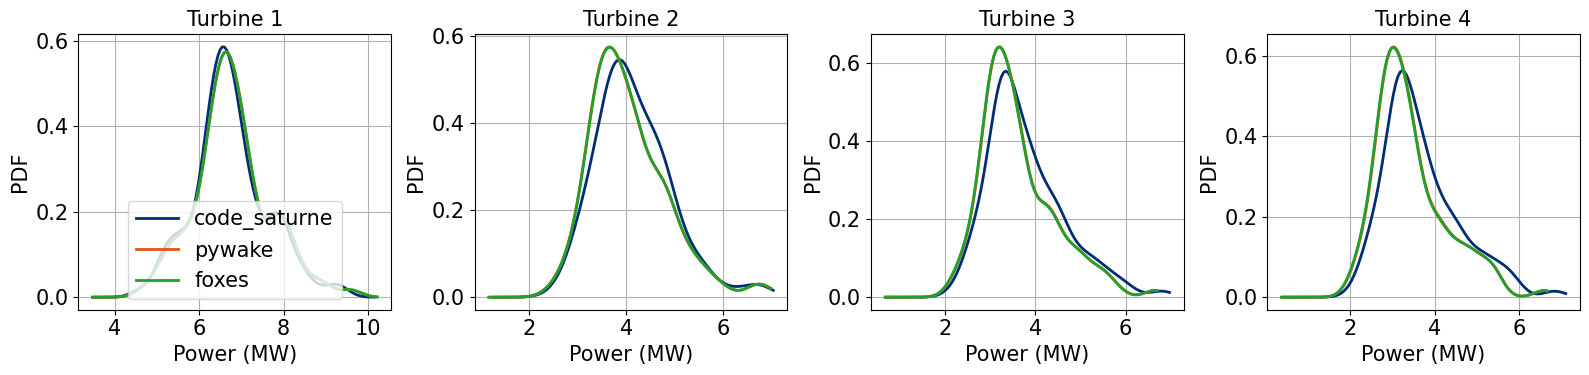

In [6]:
# read data

#power_histograms = []
code_saturne_power_KDE = []
pywake_power_KDE = []
foxes_power_KDE = []
wayves_power_KDE = []
#
power_graphs = []
kernel = ot.KernelSmoothing(ot.Normal())
for j in range(number_of_turbines):
    code_saturne_power_sample = ot.Sample([[i/10**6] for i in code_saturne_power_table[:,j]])
    pywake_power_sample = ot.Sample([[i/10**6] for i in pywake_power_table[:,j]])
    foxes_power_sample = ot.Sample([[i/10**6] for i in foxes_power_table[:,j]])
    #wayves_power_sample = ot.Sample([[i/10**6] for i in wayves_power_table[:,j]])
    
    # plot and compare to histogram
    #power_histograms.append(ot.HistogramFactory().buildAsHistogram(code_saturne_power_sample, 20))
    #power_graphs.append(power_histograms[j].drawPDF())
    
    #plot and compare empirical distributions
    code_saturne_power_KDE.append(kernel.build(code_saturne_power_sample))
    pywake_power_KDE.append(kernel.build(pywake_power_sample))
    foxes_power_KDE.append(kernel.build(foxes_power_sample))
    #wayves_power_KDE.append(kernel.build(wayves_power_sample))    
    
    #
    power_graphs.append(code_saturne_power_KDE[j].drawPDF())
    power_graphs[j].add(pywake_power_KDE[j].drawPDF())
    power_graphs[j].add(foxes_power_KDE[j].drawPDF())
    #power_graphs[j].add(wayves_power_KDE[j].drawPDF())
    #
    legend=["code_saturne", "pywake", "foxes"]
    #
    power_graphs[j].setColors(colors)
    power_graphs[j].setXTitle("Power (MW)")
    power_graphs[j].setYTitle("PDF")
    power_graphs[j].setTitle("")
    
    if(j>0):
        legend=[""]
    power_graphs[j].setLegends(legend)#, "wayves"])

fig = plt.figure(figsize=(16, 4))
axs = []
for j in range(number_of_turbines):
    axs.append(fig.add_subplot(1, number_of_turbines, j+1))
    axs[j].set_title("Turbine "+str(j+1), fontsize=15)
    _ = viewer.View(power_graphs[j], figure=fig, axes=[axs[j]])
    if(j==0):
        axs[j].legend(loc='lower center', ncol=1, fontsize=15)
    axs[j].tick_params(axis='both', which='major', labelsize=15)
    axs[j].xaxis.label.set_size(15)
    axs[j].yaxis.label.set_size(15)
    
plt.tight_layout()
plt.savefig(image_folder + sep + "power_toy_4turbines")
plt.show()
plt.clf()
plt.close()

##### with scipy

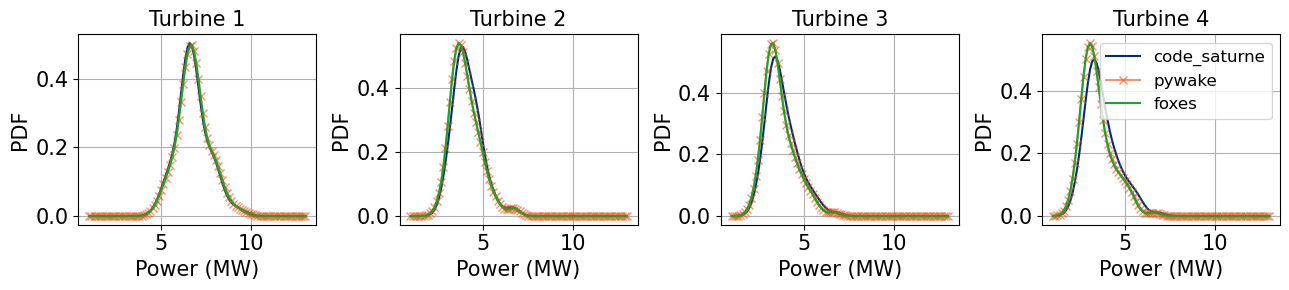

In [7]:
import scipy.stats as stats
# read data
#
fig, ax = plt.subplots(1,4,figsize=(13,3))
xs=np.linspace(1, 13, num=100)
for j in range(number_of_turbines):
    # plot and compare to histogram
    
    #plot and compare empirical distributions
    code_saturne_power_KDE = stats.gaussian_kde(code_saturne_power_table[:,j]/10**6, bw_method='silverman')
    pywake_power_KDE = stats.gaussian_kde(pywake_power_table[:,j]/10**6, bw_method='silverman')
    foxes_power_KDE = stats.gaussian_kde(foxes_power_table[:,j]/10**6, bw_method='silverman')
    #
    ax[j].set_title("Turbine "+str(j+1), fontsize=15)
    ax[j].grid(True)
    ax[j].plot(xs, code_saturne_power_KDE(xs), color=colors[0])#,  marker=markers[0], linestyle='-', alpha=0.6)
    ax[j].plot(xs, pywake_power_KDE(xs), color=colors[1], marker="x", linestyle='-', alpha=0.6)
    ax[j].plot(xs, foxes_power_KDE(xs), color=colors[2])#, marker=markers[2], linestyle='-', alpha=0.6)
    #
    ax[j].set_xlabel("Power (MW)")
    ax[j].set_ylabel("PDF")
    if(j==3):
        ax[j].legend(["code_saturne", "pywake", "foxes"], loc='upper right', ncol=1, fontsize=12)
    ax[j].tick_params(axis='both', which='major', labelsize=15)
    ax[j].xaxis.label.set_size(15)
    ax[j].yaxis.label.set_size(15)
    
    
plt.tight_layout()
plt.savefig(image_folder + sep + "power_toy_4turbines_scipy")
plt.show()
plt.clf()
plt.close()

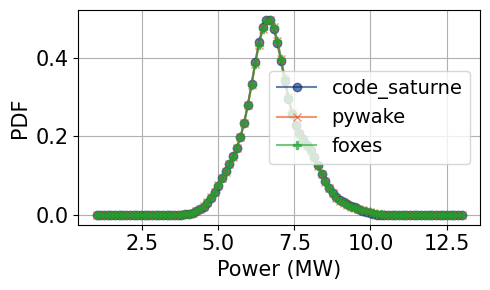

In [8]:
import scipy.stats as stats
# read data
#
fig, ax = plt.subplots(1,1,figsize=(5,3))
xs=np.linspace(1, 13, num=100)
    
#plot and compare empirical distributions
code_saturne_power_KDE = stats.gaussian_kde(code_saturne_power_table_isol/10**6, bw_method='silverman')
pywake_power_KDE = stats.gaussian_kde(pywake_power_table_isol/10**6, bw_method='silverman')
foxes_power_KDE = stats.gaussian_kde(foxes_power_table_isol/10**6, bw_method='silverman')
#
ax.grid(True)
ax.plot(xs, code_saturne_power_KDE(xs), color=colors[0], marker=markers[0], linestyle='-', alpha=0.6, label='code_saturne')
#
ax.plot(xs, pywake_power_KDE(xs), color=colors[1], marker=markers[1], linestyle='-', alpha=0.6, label='pywake')
ax.plot(xs, foxes_power_KDE(xs), color=colors[2], marker=markers[2], linestyle='-', alpha=0.6, label='foxes')
        
#
ax.set_xlabel("Power (MW)")
ax.set_ylabel("PDF")
ax.legend(loc='center right', ncol=1, fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
        
plt.tight_layout()
plt.savefig(image_folder + sep + "power_toy_isolation_scipy")
plt.show()
plt.clf()
plt.close()

## Sensitivity Analysis (SA)

### Sobol indices of power using Polynomial Chaos expansion (PCE)

In [9]:
input_variable_array = MC_sample[:MC_sample_size,:]
    
def plot_power_sobols(power_table, input_variable_array, number_of_turbines, uq_var_marginals, PC_deg = 3):
    power_sobol_indices = np.zeros((number_of_turbines,nvar))
    power_total_sobol_indices = np.zeros((number_of_turbines,nvar))
    sample_std = np.std(power_table,axis=0)
    compute_power_sobols = True
    #Show polynomials
    if(compute_power_sobols):
        copula_type = "independent"  #choices: gaussian, independent
        for i in range(number_of_turbines):
            if(number_of_turbines>1):
                std_to_test=sample_std[i]
            else:
                std_to_test=sample_std
            if(std_to_test!=0):        
                if(number_of_turbines>1):
                    fullSet = StatisticalSet(input_variable_array[:,:],power_table[:,i])
                else:
                    fullSet = StatisticalSet(input_variable_array[:,:],power_table[:])
                training_size = fullSet.setSize
                test_size = 0
                otChaosObject = OTChaos(fullSet, training_size=training_size, \
                                        test_size=test_size, prediction_size=0, number_of_sets=1)
                otChaosObject.marginals = []

                for v in range(fullSet.inputDimension):
                    otChaosObject.marginals.append(uq_var_marginals[v])
                    otChaosObject.copula = copula_type

                otChaosObject.polynomialDegree= PC_deg
                otChaosObject.construct_PCE_ot()
                chaosSI = ot.FunctionalChaosSobolIndices(otChaosObject.polynomialChaosResult) 
                for v in range(fullSet.inputDimension):                    
                    if(number_of_turbines>1):
                        power_sobol_indices[i,v] =  chaosSI.getSobolIndex(v)  
                        power_total_sobol_indices[i,v] =  chaosSI.getSobolTotalIndex(v)  
                    else:
                        power_sobol_indices[i,v] =  chaosSI.getSobolIndex(v)  
                        power_total_sobol_indices[i,v] =  chaosSI.getSobolTotalIndex(v)  

    return power_sobol_indices, power_total_sobol_indices

In [10]:
PC_deg = 3
cs_power_sobol_indices_isol, cs_power_total_sobol_indices_isol = plot_power_sobols(code_saturne_power_table_isol, input_variable_array, 1, uq_var_marginals, PC_deg = PC_deg)
pywake_power_sobol_indices_isol, pywake_power_total_sobol_indices_isol = plot_power_sobols(pywake_power_table_isol, input_variable_array, 1, uq_var_marginals, PC_deg = PC_deg)
foxes_power_sobol_indices_isol, foxes_power_total_sobol_indices_isol = plot_power_sobols(foxes_power_table_isol, input_variable_array, 1, uq_var_marginals, PC_deg = PC_deg)

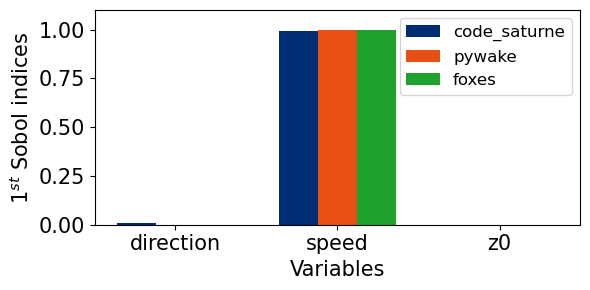

In [11]:
fig,ax = plt.subplots(1,1,figsize=(6,3))
# Bar positions
bar_width=0.24
items = uq_varnames
bar_positions1 = np.arange(len(items))
bar_positions2 = bar_positions1 + bar_width
bar_positions3 = bar_positions2 + bar_width

if(True):
    values1 = [] ; values2 = [] ; values3 = []
    for j in range(len(items)):      
        values1.append(cs_power_sobol_indices_isol[0,j])
        values2.append(pywake_power_sobol_indices_isol[0,j])
        values3.append(foxes_power_sobol_indices_isol[0,j])

    # Create bar plots
    ax.bar(bar_positions1, values1, width=bar_width, label='code_saturne', color=colors[0])
    ax.bar(bar_positions2, values2, width=bar_width, label='pywake', color=colors[1])
    ax.bar(bar_positions3, values3, width=bar_width, label='foxes', color=colors[2])

    # Set labels and title
    ax.set_xlabel('Variables')
    ax.set_ylabel(r"$1^{st}$ Sobol indices")
    # Set x-axis ticks and labels
    ax.set_xticks(bar_positions2)
    ax.set_xticklabels(items)
    ax.legend(loc="upper right", fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    ax.set_ylim(0.0,1.1)

# Show the plot
plt.tight_layout()
plt.savefig(image_folder + sep + "power_1stSobol_toy_isol")
plt.show()
plt.clf()
plt.close()

In [12]:
PC_deg = 3
cs_power_sobol_indices, cs_power_total_sobol_indices = plot_power_sobols(code_saturne_power_table, input_variable_array, number_of_turbines, uq_var_marginals, PC_deg = PC_deg)
pywake_power_sobol_indices, pywake_power_total_sobol_indices = plot_power_sobols(pywake_power_table, input_variable_array, number_of_turbines, uq_var_marginals, PC_deg = PC_deg)
foxes_power_sobol_indices, foxes_power_total_sobol_indices = plot_power_sobols(foxes_power_table, input_variable_array, number_of_turbines, uq_var_marginals, PC_deg = PC_deg)

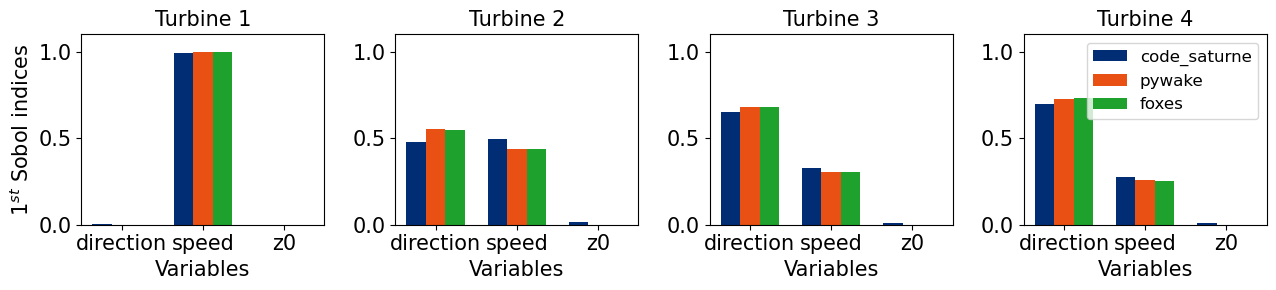

In [13]:
fig,ax = plt.subplots(1,4,figsize=(13,3))
# Bar positions
bar_width=0.24
items = uq_varnames
bar_positions1 = np.arange(len(items))
bar_positions2 = bar_positions1 + bar_width
bar_positions3 = bar_positions2 + bar_width

for i in range(number_of_turbines):
    values1 = [] ; values2 = [] ; values3 = []
    for j in range(len(items)):      
        values1.append(cs_power_sobol_indices[i,j])
        values2.append(pywake_power_sobol_indices[i,j])
        values3.append(foxes_power_sobol_indices[i,j])

    # Create bar plots
    ax[i].bar(bar_positions1, values1, width=bar_width, label='code_saturne', color=colors[0])
    ax[i].bar(bar_positions2, values2, width=bar_width, label='pywake', color=colors[1])
    ax[i].bar(bar_positions3, values3, width=bar_width, label='foxes', color=colors[2])

    # Set labels and title
    ax[i].set_xlabel('Variables')
    if(i==0):
        ax[i].set_ylabel(r"$1^{st}$ Sobol indices")
    # Set x-axis ticks and labels
    ax[i].set_xticks(bar_positions2)
    ax[i].set_xticklabels(items)
    ax[i].set_title("Turbine " + str(i+1), fontsize=15)
    if(i==3):
        ax[i].legend(loc="upper right", fontsize=12)
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[i].xaxis.label.set_size(15)
    ax[i].yaxis.label.set_size(15)
    ax[i].set_ylim(0.0,1.1)

# Show the plot
plt.tight_layout()
plt.savefig(image_folder + sep + "power_1stSobol_toy")
plt.show()
plt.clf()
plt.close()

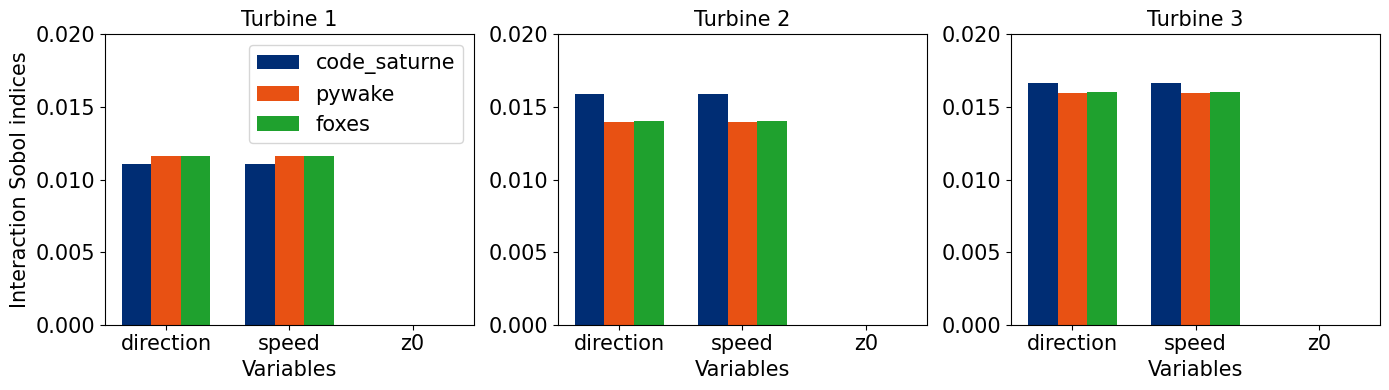

In [14]:
#The first turbine is not shown. It does not show any interaction sobols

fig,ax = plt.subplots(1,3,figsize=(14,4))
for i in range(1,number_of_turbines):
    values1 = [] ; values2 = [] ; values3 = []
    for j in range(len(items)):      
        values1.append(cs_power_total_sobol_indices[i,j]-cs_power_sobol_indices[i,j])
        values2.append(pywake_power_total_sobol_indices[i,j]-pywake_power_sobol_indices[i,j])
        values3.append(foxes_power_total_sobol_indices[i,j]-foxes_power_sobol_indices[i,j])

    # Create bar plots
    i=i-1
    ax[i].bar(bar_positions1, values1, width=bar_width, label='code_saturne', color=colors[0])
    ax[i].bar(bar_positions2, values2, width=bar_width, label='pywake', color=colors[1])
    ax[i].bar(bar_positions3, values3, width=bar_width, label='foxes', color=colors[2])

    # Set labels and title
    ax[i].set_xlabel('Variables')
    if(i==0):
        ax[i].set_ylabel(r"Interaction Sobol indices")
    # Set x-axis ticks and labels
    ax[i].set_xticks(bar_positions2)
    ax[i].set_xticklabels(items)
    ax[i].set_title("Turbine " + str(i+1),fontsize=15)
    if(i==0):
        ax[i].legend(loc="upper right", fontsize=15)
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[i].xaxis.label.set_size(15)
    ax[i].yaxis.label.set_size(15)
    ax[i].set_ylim(0.,0.02)

# Show the plot
plt.tight_layout()
plt.savefig(image_folder + sep + "power_Interaction_Sobol_toy")
plt.show()
plt.clf()
plt.close()

### Sobol indices of velocity using Polynomial Chaos expansion (PCE)

In [15]:
code_saturne_flow = nc.Dataset('flow_tools_results/code_saturne_results/windio_toy/MC_hub_timeseries_velocity_code_saturne.nc')
code_saturne_flow_isol = nc.Dataset('flow_tools_results/code_saturne_results/windio_toy/MC_hub_timeseries_isol_velocity_code_saturne.nc')

#get triangulation
triangles = code_saturne_flow.variables['triangle_vertices_ids'][:].astype(int)
npoints = len(triangles)
x_tri = code_saturne_flow.variables['vertices_x_coords'][:] ; x = np.zeros((npoints))
y_tri = code_saturne_flow.variables['vertices_y_coords'][:] ; y = np.zeros((npoints)) 

for j in range(npoints):
    i1, i2, i3 = triangles[j]
    x[j] = (x_tri[i1] + x_tri[i2] + x_tri[i3])/3. + 1872.15
    y[j] = (y_tri[i1] + y_tri[i2] + y_tri[i3])/3.
    
#get flow variables
code_saturne_velocity_magnitude = np.zeros((npoints,MC_sample_size))
code_saturne_velocity_magnitude_isol = np.zeros((npoints,MC_sample_size))
for j in range(MC_sample_size):
    code_saturne_velocity_magnitude[:,j] = np.sqrt(code_saturne_flow.variables['u'][:,j]**2 + \
                                                   code_saturne_flow.variables['v'][:,j]**2 +  \
                                                   code_saturne_flow.variables['w'][:,j]**2)    

    code_saturne_velocity_magnitude_isol[:,j] = np.sqrt(code_saturne_flow_isol.variables['u'][:,j]**2 + \
                                                   code_saturne_flow_isol.variables['v'][:,j]**2 +  \
                                                   code_saturne_flow_isol.variables['w'][:,j]**2)

In [16]:
def plot_profile_var_sobols(profile_speed, input_variable_array, uq_var_marginals, PC_deg = 3):
    profile_sobol_indices = np.zeros((len(profile_speed), nvar))
    profile_total_sobol_indices = np.zeros((len(profile_speed),nvar))
    sample_std = np.std(profile_speed,axis=1)
    sample_mean = np.mean(profile_speed,axis=1)
    compute_power_sobols = True
    #Show polynomials
    if(compute_power_sobols):
        copula_type = "independent"  #choices: gaussian, independent
        for i in range(len(profile_speed)):
            if(sample_std[i]!=0):        
                fullSet = StatisticalSet(input_variable_array[:,:],profile_speed[i,:])
                training_size = fullSet.setSize
                test_size = 0
                otChaosObject = OTChaos(fullSet, training_size=training_size, \
                                        test_size=test_size, prediction_size=0, number_of_sets=1)
                otChaosObject.marginals = []

                for v in range(fullSet.inputDimension):
                    otChaosObject.marginals.append(uq_var_marginals[v])
                    otChaosObject.copula = copula_type

                otChaosObject.polynomialDegree= PC_deg
                otChaosObject.construct_PCE_ot()
                chaosSI = ot.FunctionalChaosSobolIndices(otChaosObject.polynomialChaosResult) 
                for v in range(fullSet.inputDimension):
                    profile_sobol_indices[i,v] =  chaosSI.getSobolIndex(v)  
                    profile_total_sobol_indices[i,v] =  chaosSI.getSobolTotalIndex(v)  

    return profile_sobol_indices, profile_total_sobol_indices

In [17]:
#Points center_line
p1 = np.array([-500,0]) ; p2 = np.array([6000,0]) ; npts = 1000
center_line_coords = p1.reshape(1, -1)+np.arange(npts).reshape(-1, 1)/float(npts-1)*(p2-p1).reshape(1, -1)
center_line_speed = np.zeros((npts, MC_sample_size))
center_line_speed_isol = np.zeros((npts, MC_sample_size))

#check interpolation step
#print(center_line_coords[1:,0]-center_line_coords[0:-1,0]) 

nearest_x = [] ; nearest_y = [] ; nearest_ids = []
for j in range(code_saturne_velocity_magnitude.shape[0]):
    if(np.abs(y[j]-0.0)<100.0):
        nearest_x.append(x[j])
        nearest_y.append(y[j])
        nearest_ids.append(j)

nearest_zone_speeds = np.zeros((len(nearest_x),MC_sample_size))
nearest_zone_speeds_isol = np.zeros((len(nearest_x),MC_sample_size))
for i in range(MC_sample_size):
    nearest_zone_speeds[:,i] = code_saturne_velocity_magnitude[nearest_ids,i]
    nearest_zone_speeds_isol[:,i] = code_saturne_velocity_magnitude_isol[nearest_ids,i]
    center_line_speed[:,i] = scipy.interpolate.griddata((nearest_x, nearest_y), nearest_zone_speeds[:,i], \
                                                        (center_line_coords[:,0], center_line_coords[:,1]), \
                                                        method='linear')
    center_line_speed_isol[:,i] = scipy.interpolate.griddata((nearest_x, nearest_y), nearest_zone_speeds_isol[:,i], \
                                                        (center_line_coords[:,0], center_line_coords[:,1]), \
                                                        method='linear')

In [30]:
##
#foxes_flow = nc.Dataset('foxes_results/windio_toy/foxes_states_slices/windio_toy/slice_hh_states_windio_toy_foxes_B.nc')
#foxes_flow_isol = nc.Dataset('foxes_results/windio_toy/foxes_states_slices/windio_toy/slice_hh_states_windio_toy_foxes_B1.nc')
foxes_flow = nc.Dataset('foxes_results/windio_toy/foxes_centrelines_20240119/windio_toy/new_centreline_windio_toy_foxes_B.nc')
foxes_flow_isol = nc.Dataset('foxes_results/windio_toy/foxes_centrelines_20240119/windio_toy/new_centreline_windio_toy_foxes_B1.nc')
#
foxes_flow_blockage = nc.Dataset('foxes_results/windio_toy/foxes_centreline_blockage/windio_toy/centreline_windio_toy_foxes_D.nc')
foxes_flow_blockage_isol = nc.Dataset('foxes_results/windio_toy/foxes_centreline_blockage/windio_toy/centreline_windio_toy_foxes_D1.nc')
foxes_flow_varnames =  [key for key in foxes_flow_isol.variables.keys()] 
#
foxes_x = foxes_flow.variables["x"][:]
foxes_y = foxes_flow.variables["y"][:]
foxes_x_isol = foxes_flow_isol.variables["x"][:]
foxes_y_isol = foxes_flow_isol.variables["y"][:]
#foxes_flow_field = foxes_flow.variables["WS"][:,:,:]
#foxes_flow_field_isol = foxes_flow_isol.variables["WS"][:,:,:]
#foxes_center_line_speed = np.zeros((len(foxes_x), MC_sample_size))
#foxes_center_line_speed_isol = np.zeros((len(foxes_x_isol), MC_sample_size))
foxes_center_line_speed = foxes_flow["WS"][:,:].transpose()
foxes_center_line_speed_isol = foxes_flow_isol["WS"][:,:].transpose()

#
foxes_x_blockage = foxes_flow_blockage.variables["x"][:]
foxes_x_blockage_isol = foxes_flow_blockage_isol.variables["x"][:]
foxes_center_line_speed_blockage = foxes_flow_blockage["WS"][:,:].transpose()
foxes_center_line_speed_blockage_isol = foxes_flow_blockage_isol["WS"][:,:].transpose()
#

#for i in range(MC_sample_size):
#    foxes_interpolator = scipy.interpolate.interp2d(foxes_x, foxes_y, foxes_flow_field[i,:,:])
#    foxes_interpolator_isol = scipy.interpolate.interp2d(foxes_x_isol, foxes_y_isol,\
#                                                         foxes_flow_field_isol[i,:,:])
#    foxes_center_line_speed[:,i] = foxes_interpolator(foxes_x,0)
#    foxes_center_line_speed_isol[:,i] = foxes_interpolator_isol(foxes_x_isol,0)

In [19]:
#
pywake_flow = nc.Dataset('pywake_hh_results/pyWake_NoBlockage_eff/FarmFlow.nc')
pywake_flow_isol = nc.Dataset('pywake_hh_results/oneTurbineNoBlockage_eff/FarmFlow.nc')
pywake_flow_varnames =  [key for key in pywake_flow_isol.variables.keys()] 
print(pywake_flow_varnames)
pywake_flow_field = pywake_flow.variables["WS_eff"][:,:,0,:]
pywake_flow_field_isol = pywake_flow_isol.variables["WS_eff"][:,:,0,:]
#
pywake_x = pywake_flow.variables["x"][:]
pywake_y = pywake_flow.variables["y"][:]
pywake_x_isol = pywake_flow_isol.variables["x"][:]
pywake_y_isol = pywake_flow_isol.variables["y"][:]
pywake_center_line_speed = np.zeros((len(pywake_x), MC_sample_size))
pywake_center_line_speed_isol = np.zeros((len(pywake_x_isol), MC_sample_size))
for i in range(MC_sample_size):
    pywake_interpolator = scipy.interpolate.interp2d(pywake_x, pywake_y, pywake_flow_field[:,:,i])
    pywake_center_line_speed[:,i] = pywake_interpolator(pywake_x,0)
    #
    pywake_interpolator_isol = scipy.interpolate.interp2d(pywake_x_isol, pywake_y_isol,pywake_flow_field_isol[:,:,i])
    pywake_center_line_speed_isol[:,i] = pywake_interpolator_isol(pywake_x_isol,0)

['x', 'y', 'h', 'time', 'wd', 'ws', 'WS_eff', 'TI_eff', 'WD', 'WS', 'TI', 'P']


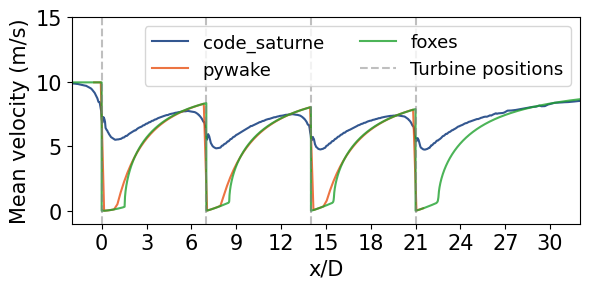

In [20]:
T_diameter=178.3

fig,ax = plt.subplots(1,1,figsize=(6,3))    
markers=[None,None,None,None]
#results of 4 turbines
ax.plot(center_line_coords[:,0]/T_diameter, np.mean(center_line_speed,axis=1), \
        color=colors[0], marker=markers[0], linestyle='-', markevery=1, alpha=0.8, label='code_saturne')
ax.plot(pywake_x/T_diameter, np.mean(pywake_center_line_speed,axis=1), \
        color=colors[1], marker=markers[1], linestyle='-', markevery=1, alpha=0.8, label='pywake')
ax.plot(foxes_x/T_diameter, np.mean(foxes_center_line_speed,axis=1), \
        color=colors[2], marker=markers[2], linestyle='-', markevery=1, alpha=0.8, label='foxes')
#ax.plot(foxes_x_blockage, np.mean(foxes_center_line_speed_blockage,axis=1), \
#        color=colors[3], marker=markers[3], linestyle='-', markevery=50, alpha=0.8, label='foxes blockage')
ax.set_ylabel("Mean velocity (m/s)")
ax.set_xlabel("x/D")
ax.set_xlim(-500/T_diameter,6000/T_diameter)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)

# Add turbines and show the plot    
turbine_x_positions = np.array([0, 1248.1, 2496.2, 3744.3])
turbine_labels = ["Turbine positions", None,None,None]
for j in range(number_of_turbines):
    ax.axvline(x=turbine_x_positions[j]/T_diameter, color='grey',linestyle='--', alpha=0.5, label=turbine_labels[j])
#
ax.legend(loc="upper right", ncol=2, fontsize=15, prop={"size":13})
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylim(-1,15)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.set_xlim(-2,32)
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

plt.tight_layout()
plt.savefig(image_folder + sep + "centerline_mean_speed_toy_4turbines")
plt.show()
plt.clf()
plt.close()

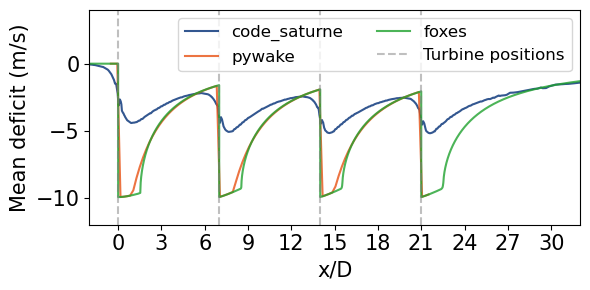

In [21]:
fig,ax = plt.subplots(1,1,figsize=(6,3))    
#results of 4 turbines
ax.plot(center_line_coords[:,0]/T_diameter, np.mean(center_line_speed-center_line_speed[0,:],axis=1), \
        color=colors[0], marker=markers[0], linestyle='-', markevery=1, alpha=0.8, label='code_saturne')
ax.plot(pywake_x/T_diameter, np.mean(pywake_center_line_speed-pywake_center_line_speed[0,:],axis=1), \
        color=colors[1], marker=markers[1], linestyle='-', markevery=1, alpha=0.8, label='pywake')
ax.plot(foxes_x/T_diameter, np.mean(foxes_center_line_speed-foxes_center_line_speed[0,:],axis=1), \
        color=colors[2], marker=markers[2], linestyle='-', markevery=1, alpha=0.8, label='foxes')
ax.set_ylabel("Mean deficit (m/s)")
ax.set_xlabel("x/D")
ax.set_xlim(-500/T_diameter,6000/T_diameter)

# Add turbines and show the plot    
turbine_x_positions = np.array([0, 1248.1, 2496.2, 3744.3])
turbine_labels = ["Turbine positions", None,None,None]
for j in range(number_of_turbines):
    ax.axvline(x=turbine_x_positions[j]/T_diameter, color='grey',linestyle='--', alpha=0.5, label=turbine_labels[j])

ax.legend(loc="upper right", ncol=2, fontsize=15, prop={"size":12})
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.set_xlim(-2,32)
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
    
ax.set_ylim(-12,4)
plt.tight_layout()
plt.savefig(image_folder + sep + "centerline_speed_deficit_toy_4turbines")
plt.show()
plt.clf()
plt.close()

/tmp/ipykernel_22715/1872322906.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


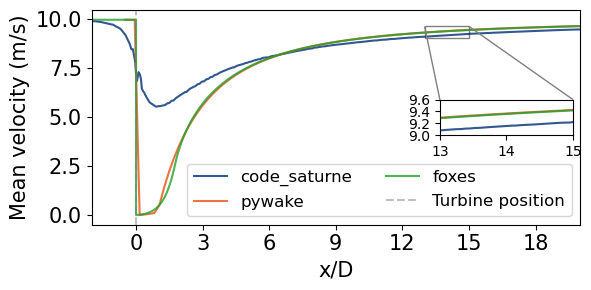

In [22]:
fig,ax = plt.subplots(1,1,figsize=(6,3))    
#results of 4 turbines
ax.plot(center_line_coords[:,0]/T_diameter, np.mean(center_line_speed_isol,axis=1), \
        color=colors[0], marker=markers[0], linestyle='-', markevery=1, alpha=0.8, label='code_saturne')
ax.plot(pywake_x_isol/T_diameter, np.mean(pywake_center_line_speed_isol,axis=1), \
        color=colors[1], marker=markers[1], linestyle='-', markevery=1, alpha=0.8, label='pywake')
ax.plot(foxes_x_isol/T_diameter, np.mean(foxes_center_line_speed_isol,axis=1), \
        color=colors[2], marker=markers[2], linestyle='-', markevery=1, alpha=0.8, label='foxes')
#ax.plot(foxes_x_blockage_isol, np.mean(foxes_center_line_speed_blockage_isol,axis=1), \
#        color=colors[3], marker=markers[3], linestyle='-', markevery=30, alpha=0.8, label='foxes blockage')
ax.set_ylabel("Mean velocity (m/s)")
ax.set_xlabel("x/D")
ax.set_xlim(-500/T_diameter,3000/T_diameter)
#
#ax.set_xlim(2500,3000)
#ax.set_ylim(9.5,10.)
#

#Insert zoomed figure
axins = zoomed_inset_axes(ax, 3, loc="center right")
axins.plot(center_line_coords[:,0]/T_diameter, np.mean(center_line_speed_isol,axis=1), \
        color=colors[0], marker=markers[0], linestyle='-', markevery=2, alpha=0.8, label='code_saturne')
axins.plot(pywake_x_isol/T_diameter, np.mean(pywake_center_line_speed_isol,axis=1), \
        color=colors[1], marker=markers[1], linestyle='-', markevery=2, alpha=0.8, label='pywake')
axins.plot(foxes_x_isol/T_diameter, np.mean(foxes_center_line_speed_isol,axis=1), \
        color=colors[2], marker=markers[2], linestyle='-', markevery=5, alpha=0.8, label='foxes')
axins.set_xlim(13,15)#2500/T_diameter,3000/T_diameter)
axins.set_ylim(9.0,9.6)
axins.set_yticks([9.0,9.2,9.4,9.6])
#axins.set_xticks([2500/T_diameter,2700/T_diameter,2900/T_diameter])
#axins.set_xticks([14,15,16,17])
mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5")

#
# Add turbines and show the plot    
turbine_x_positions = np.array([0, 1248.1, 2496.2, 3744.3])
turbine_labels = ["Turbine position", None,None,None]
for j in range(1):
    ax.axvline(x=turbine_x_positions[j]/T_diameter,
               color='grey',linestyle='--', alpha=0.5, label=turbine_labels[j])

ax.legend(loc="lower right", ncol=2, fontsize=15, prop={"size":12})
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)

ax.set_xlim(-2,20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

plt.tight_layout()
plt.savefig(image_folder + sep + "centerline_mean_speed_toy_isol")
plt.show()
plt.clf()
plt.close()

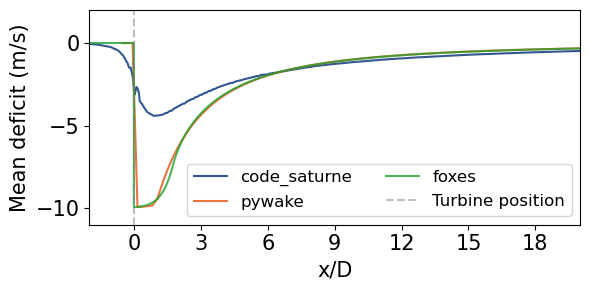

In [23]:
fig,ax = plt.subplots(1,1,figsize=(6,3))    
#results of 4 turbines
ax.plot(center_line_coords[:,0]/T_diameter, np.mean(center_line_speed_isol-center_line_speed_isol[0,:],axis=1), \
        color=colors[0], marker=markers[0], linestyle='-', markevery=1, alpha=0.8, label='code_saturne')
ax.plot(pywake_x_isol/T_diameter, np.mean(pywake_center_line_speed_isol-pywake_center_line_speed_isol[0,:],axis=1), \
        color=colors[1], marker=markers[1], linestyle='-', markevery=1, alpha=0.8, label='pywake')
ax.plot(foxes_x_isol/T_diameter, np.mean(foxes_center_line_speed_isol-foxes_center_line_speed_isol[0,:],axis=1), \
        color=colors[2], marker=markers[2], linestyle='-', markevery=1, alpha=0.8, label='foxes')
ax.set_ylabel("Mean deficit (m/s)")
ax.set_xlabel("x/D")
ax.set_xlim(-500/T_diameter,6000/T_diameter)

# Add turbines and show the plot    
turbine_x_positions = np.array([0, 1248.1, 2496.2, 3744.3])
turbine_labels = ["Turbine position", None,None,None]
for j in range(1):
    ax.axvline(x=turbine_x_positions[j]/T_diameter, color='grey',linestyle='--', alpha=0.5, label=turbine_labels[j])

ax.legend(loc="lower right", ncol=2, fontsize=15, prop={"size":12})
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.set_ylim(-11,2)
ax.set_xlim(-2,20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

plt.tight_layout()
plt.savefig(image_folder + sep + "centerline_speed_deficit_toy_isol")
plt.show()
plt.clf()
plt.close()

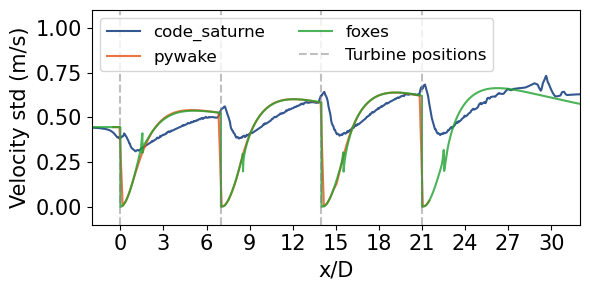

In [24]:
fig,ax = plt.subplots(1,1,figsize=(6,3))    
#results of 4 turbines
ax.plot(center_line_coords[:,0]/T_diameter, np.std(center_line_speed,axis=1), \
        color=colors[0], marker=markers[0], linestyle='-', markevery=1, alpha=0.8, label='code_saturne')
ax.plot(pywake_x/T_diameter, np.std(pywake_center_line_speed,axis=1), \
        color=colors[1], marker=markers[1], linestyle='-', markevery=1, alpha=0.8, label='pywake')
ax.plot(foxes_x/T_diameter, np.std(foxes_center_line_speed,axis=1), \
        color=colors[2], marker=markers[2], linestyle='-', markevery=1, alpha=0.8, label='foxes')
#ax.plot(foxes_x, foxes_speed, \
#        color=colors[1], marker=markers[1], linestyle='-', markevery=50, alpha=0.8, label='foxes')
ax.set_ylabel("Velocity std (m/s)")
ax.set_xlabel("x/D")
ax.set_xlim(-500/T_diameter,7000/T_diameter)

# Add turbines and show the plot    
turbine_x_positions = np.array([0, 1248.1, 2496.2, 3744.3])
turbine_labels = ["Turbine positions", None,None,None]
for j in range(number_of_turbines):
    ax.axvline(x=turbine_x_positions[j]/T_diameter, color='grey',linestyle='--', alpha=0.5, label=turbine_labels[j])

ax.legend(loc="upper left", ncol=2, fontsize=15, prop={"size":12})
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.set_xlim(-2,32)
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
ax.set_ylim(-0.1,1.1)

plt.tight_layout()
plt.savefig(image_folder + sep + "centerline_std_speed_toy_4turbines")
plt.show()
plt.clf()
plt.close()

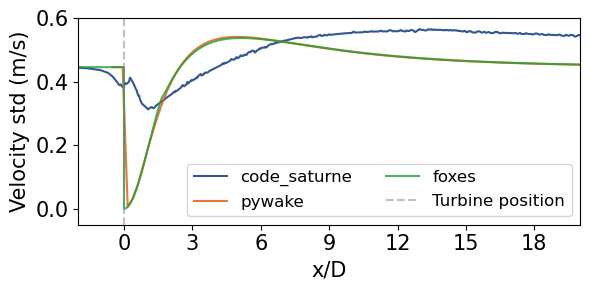

In [25]:
fig,ax = plt.subplots(1,1,figsize=(6,3))    
#results of 4 turbines
ax.plot(center_line_coords[:,0]/T_diameter, np.std(center_line_speed_isol,axis=1), \
        color=colors[0], marker=markers[0], linestyle='-', markevery=1, alpha=0.8, label='code_saturne')
ax.plot(pywake_x_isol/T_diameter, np.std(pywake_center_line_speed_isol,axis=1), \
        color=colors[1], marker=markers[1], linestyle='-', markevery=1, alpha=0.8, label='pywake')
ax.plot(foxes_x_isol/T_diameter, np.std(foxes_center_line_speed_isol,axis=1), \
        color=colors[2], marker=markers[2], linestyle='-', markevery=1, alpha=0.8, label='foxes')
#ax.plot(foxes_x, foxes_speed, \
#        color=colors[1], marker=markers[1], linestyle='-', markevery=50, alpha=0.8, label='foxes')
ax.set_ylabel("Velocity std (m/s)")
ax.set_xlabel("x/D")
ax.set_xlim(-500/T_diameter,3000/T_diameter)
ax.set_ylim(0,0.6)

# Add turbines and show the plot    
turbine_x_positions = np.array([0, 1248.1, 2496.2, 3744.3])
turbine_labels = ["Turbine position", None,None,None]
for j in range(1):
    ax.axvline(x=turbine_x_positions[j]/T_diameter, color='grey',linestyle='--', alpha=0.5, label=turbine_labels[j])

    
ax.legend(loc="lower right", ncol=2, fontsize=15, prop={"size":12})
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.set_xlim(-2,20)
ax.set_ylim(-0.05,0.6)
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
    
plt.tight_layout()
plt.savefig(image_folder + sep + "centerline_std_speed_toy_isol")
plt.show()
plt.clf()
plt.close()

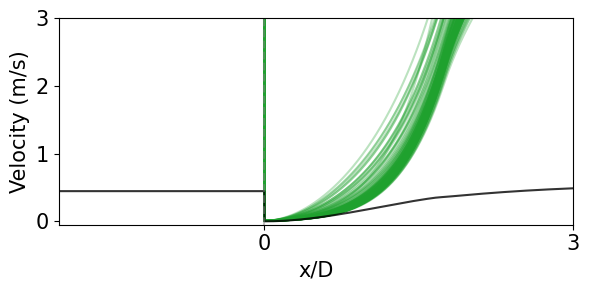

In [26]:
fig,ax = plt.subplots(1,1,figsize=(6,3))    
#results of 4 turbines
for j in range(MC_sample_size):
    ax.plot(foxes_x_isol/T_diameter,foxes_center_line_speed_isol[:,j], \
            color=colors[2], marker=markers[2], linestyle='-', markevery=1, alpha=0.3)

ax.plot(foxes_x_isol/T_diameter, np.std(foxes_center_line_speed_isol,axis=1), \
        color='k', marker=markers[2], linestyle='-', markevery=1, alpha=0.8, label='foxes')

ax.set_ylabel("Velocity (m/s)")
ax.set_xlabel("x/D")
ax.set_xlim(-500/T_diameter,3000/T_diameter)

# Add turbines and show the plot    
turbine_x_positions = np.array([0, 1248.1, 2496.2, 3744.3])
turbine_labels = ["Turbine position", None,None,None]
for j in range(1):
    ax.axvline(x=turbine_x_positions[j]/T_diameter, color='grey',linestyle='--', alpha=0.5, label=turbine_labels[j])

ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.set_xlim(-2,3)
ax.set_ylim(-0.05,3)
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
    
plt.tight_layout()
plt.savefig(image_folder + sep + "foxes_centerline_speed_toy_isol")
plt.show()
plt.clf()
plt.close()

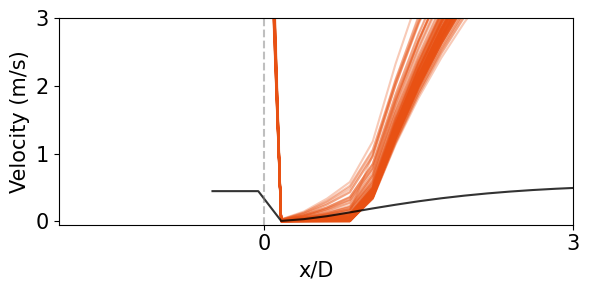

In [50]:
fig,ax = plt.subplots(1,1,figsize=(6,3))    
#results of 4 turbines
for j in range(MC_sample_size):
    ax.plot(pywake_x_isol/T_diameter,pywake_center_line_speed_isol[:,j], \
            color=colors[1], marker=markers[2], linestyle='-', markevery=1, alpha=0.3)

ax.plot(pywake_x_isol/T_diameter, np.std(pywake_center_line_speed_isol,axis=1), \
        color='k', marker=markers[2], linestyle='-', markevery=1, alpha=0.8, label='foxes')

ax.set_ylabel("Velocity (m/s)")
ax.set_xlabel("x/D")
ax.set_xlim(-500/T_diameter,3000/T_diameter)

# Add turbines and show the plot    
turbine_x_positions = np.array([0, 1248.1, 2496.2, 3744.3])
turbine_labels = ["Turbine position", None,None,None]
for j in range(1):
    ax.axvline(x=turbine_x_positions[j]/T_diameter, color='grey',linestyle='--', alpha=0.5, label=turbine_labels[j])

ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.set_xlim(-2,3)
ax.set_ylim(-0.05,3)
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
    
plt.tight_layout()
plt.savefig(image_folder + sep + "pywake_centerline_speed_toy_isol")
plt.show()
plt.clf()
plt.close()

In [28]:
cs_center_line_sobol_indices, cs_center_line_total_sobol_indices = plot_profile_var_sobols(center_line_speed, 
                                                                                    input_variable_array, 
                                                                                    uq_var_marginals, PC_deg = 3)
cs_center_line_sobol_indices_isol, cs_center_line_total_sobol_indices_isol = plot_profile_var_sobols(center_line_speed_isol, 
                                                                                    input_variable_array, 
                                                                                    uq_var_marginals, PC_deg = 3)

In [31]:
pywake_center_line_sobol_indices, pywake_center_line_total_sobol_indices = plot_profile_var_sobols(pywake_center_line_speed, 
                                                                                    input_variable_array, 
                                                                                    uq_var_marginals, PC_deg = 3)
pywake_center_line_sobol_indices_isol, pywake_center_line_total_sobol_indices_isol = plot_profile_var_sobols(pywake_center_line_speed_isol, 
                                                                                    input_variable_array, 
                                                                                    uq_var_marginals, PC_deg = 3)

foxes_center_line_sobol_indices, foxes_center_line_total_sobol_indices = plot_profile_var_sobols(foxes_center_line_speed, 
                                                                                    input_variable_array, 
                                                                                    uq_var_marginals, PC_deg = 3)
foxes_center_line_sobol_indices_isol, foxes_center_line_total_sobol_indices_isol = plot_profile_var_sobols(foxes_center_line_speed_isol, 
                                                                                    input_variable_array, 
                                                                                    uq_var_marginals, PC_deg = 3)

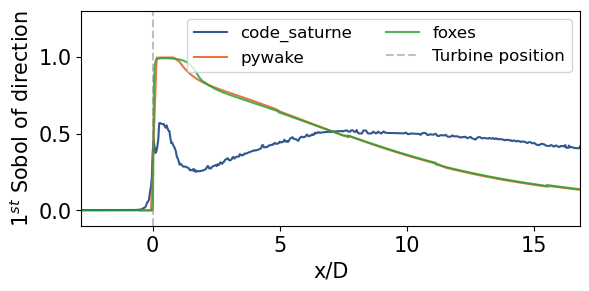

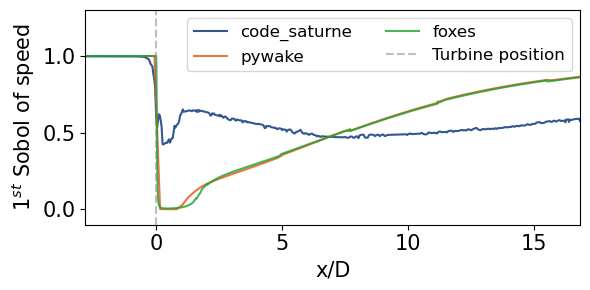

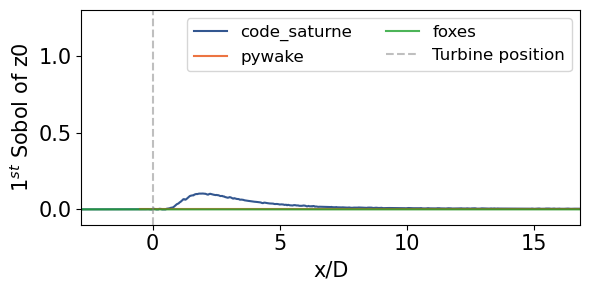

In [32]:
for v in range(len(uq_varnames)):
    fig,ax = plt.subplots(1,1,figsize=(6,3))   
    ax.plot(center_line_coords[:,0]/T_diameter, cs_center_line_sobol_indices_isol[:,v], color=colors[0], \
            marker=markers[0], linestyle='-', markevery=1, alpha=0.8, label='code_saturne')
    ax.plot(pywake_x_isol/T_diameter, pywake_center_line_sobol_indices_isol[:,v], color=colors[1], \
            marker=markers[1], linestyle='-', markevery=1, alpha=0.8, label='pywake')
    ax.plot(foxes_x_isol/T_diameter, foxes_center_line_sobol_indices_isol[:,v], color=colors[2], \
            marker=markers[2], linestyle='-', markevery=1, alpha=0.8, label='foxes')
    ax.set_ylabel(r"$1^{st}$ Sobol of "+uq_varnames[v])
    #ax.plot(center_line_coords[:,0], center_line_total_sobol_indices[:,v]-center_line_sobol_indices[:,v], color=colors[v], label='')
    #ax.plot(center_line_coords[:,0], center_line_total_sobol_indices_isol[:,v]-center_line_sobol_indices_isol[:,v], color=colors[v], label=None, linestyle='--')
    #ax.set_ylabel("Interaction Sobol indices")
    ax.set_xlabel("x/D")
    ax.set_xlim(-500/T_diameter,3000/T_diameter)
    #
    # Add turbines and show the plot    
    turbine_x_positions = np.array([0, 1248.1, 2496.2, 3744.3])
    turbine_labels = ["Turbine position", None,None,None]
    for j in range(1):
        ax.axvline(x=turbine_x_positions[j]/T_diameter, color='grey',linestyle='--', alpha=0.5, label=turbine_labels[j])
    #
    ax.legend(loc="upper right", ncol=2, fontsize=15, prop={"size":12})
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    ax.set_ylim(-0.1,1.3)
    #
    plt.tight_layout()
    plt.savefig(image_folder + sep + "centerline_"+uq_varnames[v]+"_FirstSobol_toy_isol")
    plt.show()
    plt.clf()
    plt.close()

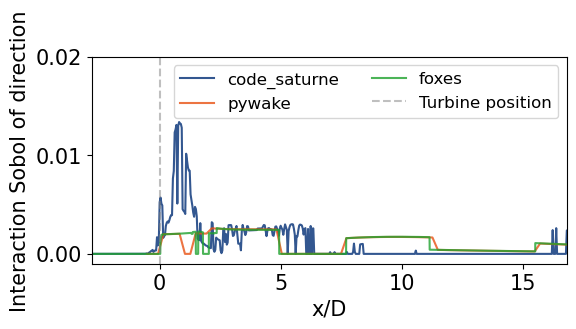

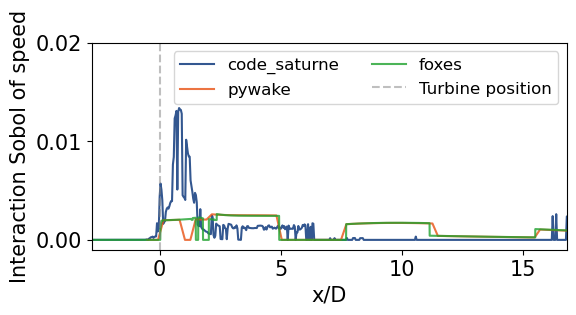

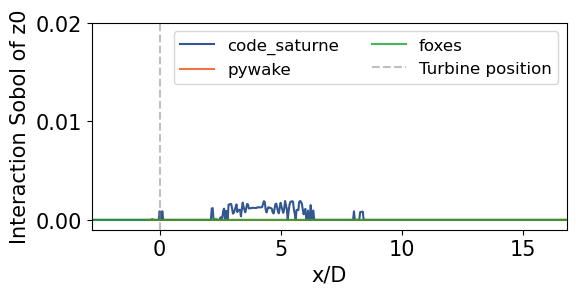

In [33]:
for v in range(len(uq_varnames)):
    fig,ax = plt.subplots(1,1,figsize=(6,3))   
    ax.plot(center_line_coords[:,0]/T_diameter, cs_center_line_total_sobol_indices_isol[:,v]-cs_center_line_sobol_indices_isol[:,v], color=colors[0], \
            marker=markers[0], linestyle='-', markevery=2, alpha=0.8, label='code_saturne')
    ax.plot(pywake_x_isol/T_diameter, pywake_center_line_total_sobol_indices_isol[:,v]-pywake_center_line_sobol_indices_isol[:,v], color=colors[1], \
            marker=markers[1], linestyle='-', markevery=2, alpha=0.8, label='pywake')
    ax.plot(foxes_x_isol/T_diameter, foxes_center_line_total_sobol_indices_isol[:,v]-foxes_center_line_sobol_indices_isol[:,v], color=colors[2], \
            marker=markers[2], linestyle='-', markevery=2, alpha=0.8, label='foxes')
    ax.set_ylabel(r"Interaction Sobol of "+uq_varnames[v])
    #ax.plot(center_line_coords[:,0], center_line_total_sobol_indices[:,v]-center_line_sobol_indices[:,v], color=colors[v], label='')
    #ax.plot(center_line_coords[:,0], center_line_total_sobol_indices_isol[:,v]-center_line_sobol_indices_isol[:,v], color=colors[v], label=None, linestyle='--')
    #ax.set_ylabel("Interaction Sobol indices")
    ax.set_xlabel("x/D")
    ax.set_xlim(-500/T_diameter,3000/T_diameter)
    #
    # Add turbines and show the plot    
    turbine_x_positions = np.array([0, 1248.1, 2496.2, 3744.3])
    turbine_labels = ["Turbine position", None,None,None]
    for j in range(1):
        ax.axvline(x=turbine_x_positions[j]/T_diameter, color='grey',linestyle='--', alpha=0.5, label=turbine_labels[j])
    
    ax.legend(loc="upper right", ncol=2, fontsize=15, prop={"size":12})
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    ax.set_ylim(-0.001,0.02)
    plt.tight_layout()
    plt.savefig(image_folder + sep + "centerline_"+uq_varnames[v]+"_InteractionSobol_toy_isol")
    plt.show()
    plt.clf()
    plt.close()

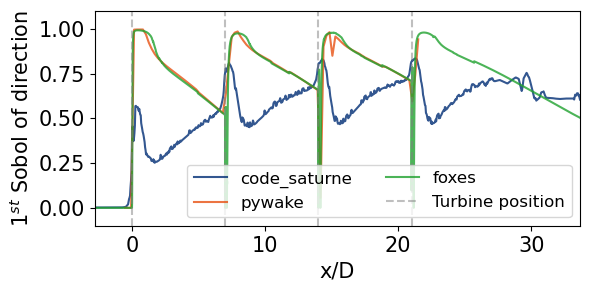

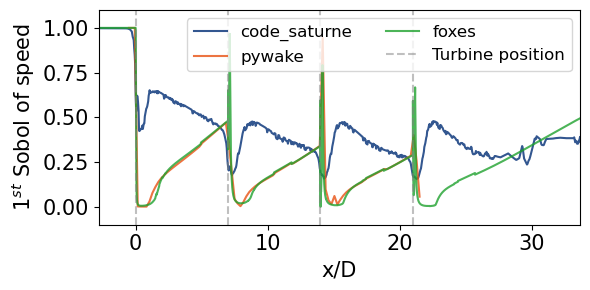

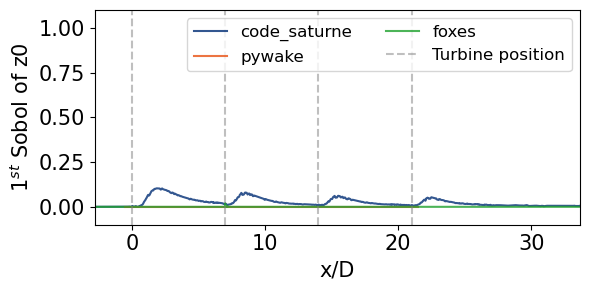

In [34]:
for v in range(len(uq_varnames)):
    fig,ax = plt.subplots(1,1,figsize=(6,3))   
    ax.plot(center_line_coords[:,0]/T_diameter, cs_center_line_sobol_indices[:,v], color=colors[0], \
            marker=markers[0], linestyle='-', markevery=2, alpha=0.8, label='code_saturne')
    ax.plot(pywake_x/T_diameter, pywake_center_line_sobol_indices[:,v], color=colors[1], \
            marker=markers[1], linestyle='-', markevery=2, alpha=0.8, label='pywake')
    ax.plot(foxes_x/T_diameter, foxes_center_line_sobol_indices[:,v], color=colors[2], \
            marker=markers[2], linestyle='-', markevery=2, alpha=0.8, label='foxes')
    ax.set_ylabel(r"$1^{st}$ Sobol of "+uq_varnames[v])
    #ax.plot(center_line_coords[:,0], center_line_total_sobol_indices[:,v]-center_line_sobol_indices[:,v], color=colors[v], label='')
    #ax.plot(center_line_coords[:,0], center_line_total_sobol_indices_isol[:,v]-center_line_sobol_indices_isol[:,v], color=colors[v], label=None, linestyle='--')
    #ax.set_ylabel("Interaction Sobol indices")
    ax.set_xlabel("x/D")
    ax.set_xlim(-500/T_diameter,6000/T_diameter)
    #
    # Add turbines and show the plot    
    turbine_x_positions = np.array([0, 1248.1, 2496.2, 3744.3])
    turbine_labels = ["Turbine position", None,None,None]
    for j in range(4):
        ax.axvline(x=turbine_x_positions[j]/T_diameter, color='grey',linestyle='--', alpha=0.5, label=turbine_labels[j])
        
    if(v==0):
        loc="lower right"
    else:
        loc="upper right"
    ax.legend(loc=loc, ncol=2, fontsize=15, prop={"size":12})
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    #
    ax.set_ylim(-0.1,1.1)
    plt.tight_layout()
    plt.savefig(image_folder + sep + "centerline_"+uq_varnames[v]+"_FirstSobol_toy_4turbines")
    plt.show()
    plt.clf()
    plt.close()

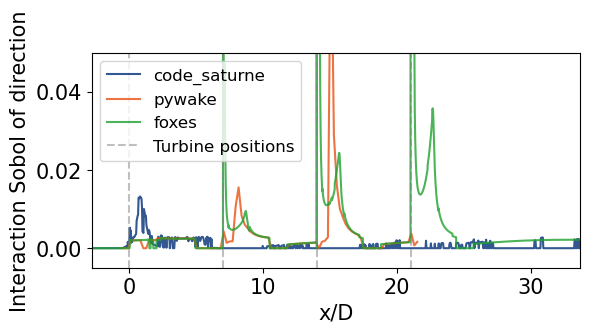

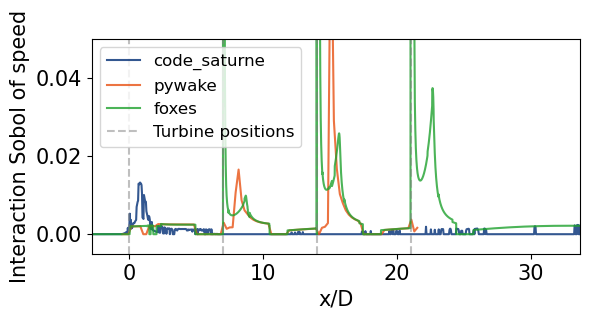

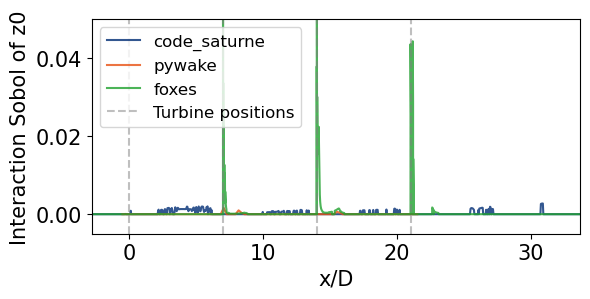

In [35]:
for v in range(len(uq_varnames)):
    fig,ax = plt.subplots(1,1,figsize=(6,3))   
    ax.plot(center_line_coords[:,0]/T_diameter, cs_center_line_total_sobol_indices[:,v]-cs_center_line_sobol_indices[:,v], color=colors[0], \
            marker=markers[0], linestyle='-', markevery=2, alpha=0.8, label='code_saturne')
    ax.plot(pywake_x/T_diameter, pywake_center_line_total_sobol_indices[:,v]-pywake_center_line_sobol_indices[:,v], color=colors[1], \
            marker=markers[1], linestyle='-', markevery=2, alpha=0.8, label='pywake')
    ax.plot(foxes_x/T_diameter, foxes_center_line_total_sobol_indices[:,v]-foxes_center_line_sobol_indices[:,v], color=colors[2], \
            marker=markers[2], linestyle='-', markevery=2, alpha=0.8, label='foxes')
    ax.set_ylabel(r"Interaction Sobol of "+uq_varnames[v])
    #ax.plot(center_line_coords[:,0], center_line_total_sobol_indices[:,v]-center_line_sobol_indices[:,v], color=colors[v], label='')
    #ax.plot(center_line_coords[:,0], center_line_total_sobol_indices_isol[:,v]-center_line_sobol_indices_isol[:,v], color=colors[v], label=None, linestyle='--')
    #ax.set_ylabel("Interaction Sobol indices")
    ax.set_xlabel("x/D")
    ax.set_xlim(-500/T_diameter,6000/T_diameter)
    #
    # Add turbines and show the plot    
    turbine_x_positions = np.array([0, 1248.1, 2496.2, 3744.3])
    turbine_labels = ["Turbine positions", None,None,None]
    for j in range(4):
        ax.axvline(x=turbine_x_positions[j]/T_diameter, color='grey',linestyle='--', alpha=0.5, label=turbine_labels[j])
    
    ax.legend(loc="upper left", ncol=1, fontsize=15, prop={"size":12})
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    #
    ax.set_ylim(-0.005,0.05)
    
    plt.tight_layout()
    plt.savefig(image_folder + sep + "centerline_"+uq_varnames[v]+"_InteractionSobol_toy_4turbines")
    plt.show()
    plt.clf()
    plt.close()

In [32]:
write_centerline_in_nc = False
if(write_centerline_in_nc):
    nc_file_name = "flow_tools_results/code_saturne_results/windio_toy/SA_timeseries_centerline_code_saturne.nc"
    ds = nc.Dataset(nc_file_name, 'w', format='NETCDF4')

    #Declare dimensions
    x_coords = ds.createDimension('x', center_line_coords.shape[0])
    x_coords = ds.createVariable('x', 'f4', ('x',))
    x_coords[:] = center_line_coords[:,0]
    
    #Declare variables
    speed_mean = ds.createVariable('speed_mean', 'f4', ('x'))
    speed_mean.units = 'm/s'
    speed_mean[:] = np.mean(center_line_speed,axis=1)
    speed_std = ds.createVariable('speed_std', 'f4', ('x'))
    speed_std.units = 'm/s'
    speed_std[:] = np.std(center_line_speed,axis=1)
    #
    sobol_index_1st_list = []
    sobol_index_total_list = []
    for j in range(nvar):
        #declare
        sobol_index_1st_list.append(ds.createVariable(uq_varnames[j]+'_sobol_index_1st', 'f4', ('x')))
        sobol_index_1st_list[j].units = ''
        sobol_index_total_list.append(ds.createVariable(uq_varnames[j]+'_sobol_index_total', 'f4', ('x')))
        sobol_index_total_list[j].units = ''
        #fill
        sobol_index_1st_list[j][:] = center_line_sobol_indices[:,j]
        sobol_index_total_list[j][:] = center_line_total_sobol_indices[:,j]

    ds.close()

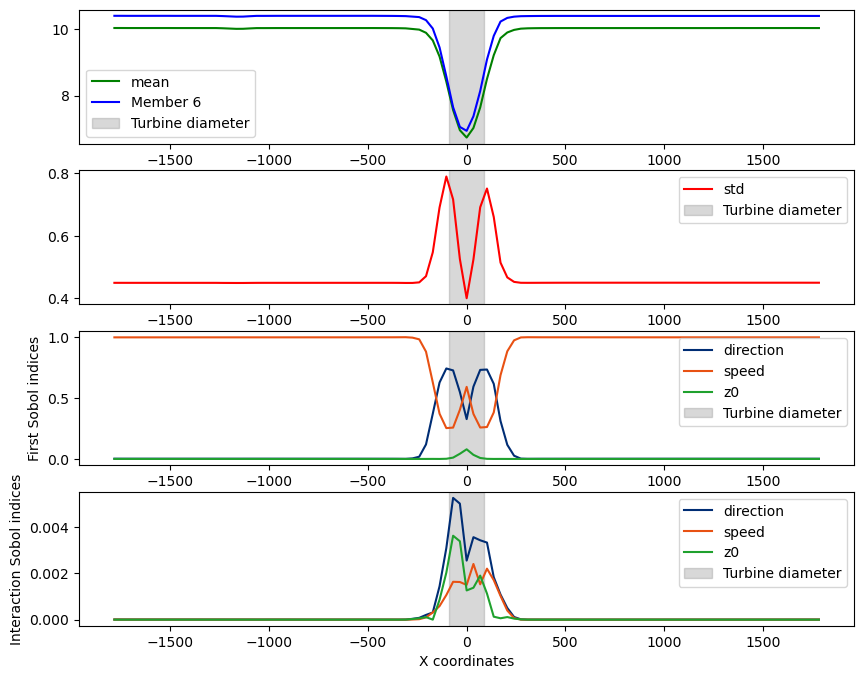

In [124]:
#Points cross_line
turbine_x_positions = np.array([0, 1248.1, 2496.2, 3744.3]) - 1872.15
turbine_diameter = 178.3
p1 = np.array([turbine_x_positions[0] + 3*turbine_diameter ,0-10*turbine_diameter]) ; p2 = np.array([turbine_x_positions[0] + 3*turbine_diameter,0+10*turbine_diameter]) ; npts = 105
cross_line_coords = p1.reshape(1, -1)+np.arange(npts).reshape(-1, 1)/float(npts-1)*(p2-p1).reshape(1, -1)
cross_line_speed = np.zeros((npts, MC_sample_size))

nearest_x = [] ; nearest_y = [] ; nearest_ids = []
for j in range(code_saturne_velocity_magnitude.shape[0]):
    if(np.abs(x[j]-(turbine_x_positions[0] + 3*turbine_diameter))<100.0):
        nearest_x.append(x[j])
        nearest_y.append(y[j])
        nearest_ids.append(j)

nearest_zone_speeds = np.zeros((len(nearest_x),MC_sample_size))
for i in range(MC_sample_size):
    nearest_zone_speeds[:,i] = code_saturne_velocity_magnitude[nearest_ids,i]
    cross_line_speed[:,i] = scipy.interpolate.griddata((nearest_x, nearest_y), nearest_zone_speeds[:,i], \
                                                        (cross_line_coords[:,0], cross_line_coords[:,1]), \
                                                        method='linear')

    
cross_line_sobol_indices, cross_line_total_sobol_indices = plot_profile_var_sobols(cross_line_speed, 
                                                                                    input_variable_array, 
                                                                                    uq_var_marginals, PC_deg = 3)

fig,ax = plt.subplots(4,1,figsize=(10,8))    

#results of 4 turbines
ax[0].plot(cross_line_coords[:,1], np.mean(cross_line_speed,axis=1), 'g-', label='mean')
ax[0].plot(cross_line_coords[:,1], cross_line_speed[:,5], 'b-', label='Member 6')
ax[1].plot(cross_line_coords[:,1], np.std(cross_line_speed,axis=1), 'r-', label='std')
#
for v in range(nvar):
    ax[2].plot(cross_line_coords[:,1], cross_line_sobol_indices[:,v], color=colors[v], label=uq_varnames[v])
    ax[2].set_ylabel("First Sobol indices")
for v in range(nvar):
    ax[3].plot(cross_line_coords[:,1], cross_line_total_sobol_indices[:,v]-cross_line_sobol_indices[:,v], color=colors[v], label=uq_varnames[v])
    ax[3].set_ylabel("Interaction Sobol indices")
    ax[3].set_xlabel("X coordinates")
    
for i in range(4):
    ax[i].axvspan(xmin=-0.5*turbine_diameter, xmax=0.5*turbine_diameter, \
                  color='grey',alpha=0.3, label="Turbine diameter")
    ax[i].legend()
plt.show()

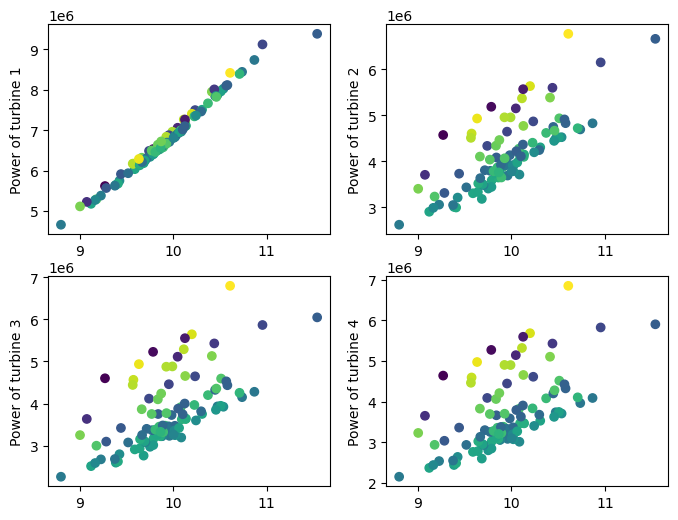

In [249]:
### Scatter plot example
power_table = code_saturne_power_table
power_table_isol = code_saturne_power_table_isol
MC_direction = MC_sample[:MC_sample_size,0]
MC_speed = MC_sample[:MC_sample_size,1]
MC_z0 = MC_sample[:MC_sample_size,2]

fig,ax = plt.subplots(2,2,figsize=(8,6))
dependency_var = MC_speed
color_var = MC_direction
ax[0,0].scatter(dependency_var, power_table_isol[:], c=color_var, label='test')
ax[0,0].set_ylabel('Power of turbine 1')
ax[0,1].scatter(dependency_var, power_table[:,1], c=color_var)
ax[0,1].set_ylabel('Power of turbine 2')
ax[1,0].scatter(dependency_var, power_table[:,2], c=color_var)
ax[1,0].set_ylabel('Power of turbine 3')
ax[1,1].scatter(dependency_var, power_table[:,3], c=color_var)
ax[1,1].set_ylabel('Power of turbine 4')
plt.show()

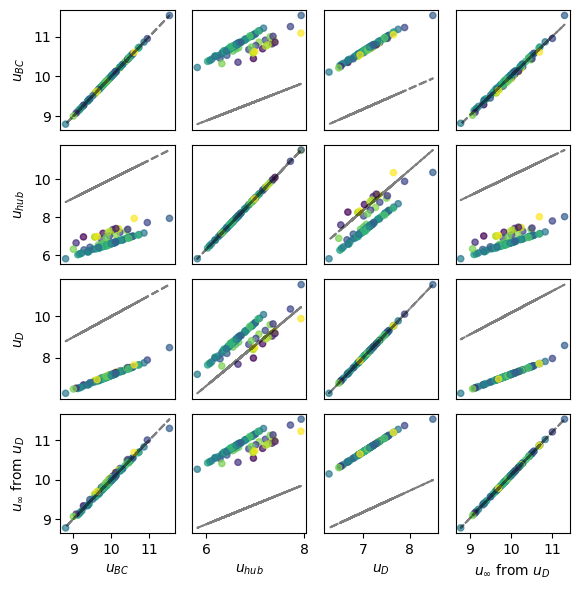

In [250]:
###Scatter plot velocities 
variables_to_scatter = np.zeros((len(MC_speed),4))
variables_to_scatter[:,0] = MC_speed ; variables_to_scatter[:,1] = code_saturne_uhub
variables_to_scatter[:,2] = code_saturne_udisk ; variables_to_scatter[:,3] = code_saturne_deduced_freestream
legend_varnames = [r"$u_{BC}$" , r"$u_{hub}$", r"$u_{D}$", "$u_{\infty}$ from $u_{D}$"]
#
nvar=len(legend_varnames)
fig, axs = plt.subplots(nrows=nvar,ncols=nvar, figsize=(6, 6))
for i in range(nvar):
    for j in range(nvar):
        # Plot data in each subplot
        axs[i, j].plot(variables_to_scatter[:,j],variables_to_scatter[:,j], 'k--', alpha=0.5)
        axs[i, j].scatter(variables_to_scatter[:,j], variables_to_scatter[:,i], c=MC_direction, s=20, alpha=0.7)
        #axs[i, j].set_title('Scatter Plot '+str(i)+' '+str(j))
        #
        axs[i, j].tick_params(axis="x",which="both",labelbottom=False, bottom=False, top=False)
        axs[i, j].tick_params(axis="y",which="both",labelleft=False, left=False, right=False)
        if(j==0):
            axs[i, j].set(ylabel=legend_varnames[i])
            axs[i, j].tick_params(axis="y",which="both",labelleft=True, left=True)
        if(i==nvar-1):
            axs[i, j].set(xlabel=legend_varnames[j])
            axs[i, j].tick_params(axis="x",which="both",labelbottom=True, bottom=True)

plt.tight_layout()
plt.show()

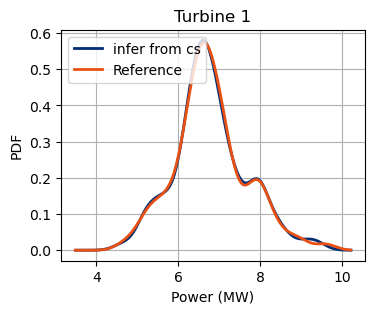

In [253]:
###Verify turbine power with the different velocities 
speeds = [4.,5.,6.,7.,8.,9.,10.,11.,12.,13.,14.,15.,16.,17.,18.,19.,20.,21.,22.,23.,24.,25.]
powers = [263388., 751154., 1440738., 2355734., 3506858., 4993092., 6849310., 9116402., 10000754., 10009590., 10000942., 10042678., 10003480., 10001600., 10001506., 10013632., 10007428., 10005360., 10002728., 10001130., 10004984., 9997558.]
power_interpolator = scipy.interpolate.interp1d(speeds,powers)    
infer_power_from_cs = power_interpolator(code_saturne_deduced_freestream)
infer_power_from_sample = power_interpolator(MC_speed)

#power_histograms = []
code_saturne_power_KDE = []
pywake_power_KDE = []
foxes_power_KDE = []
wayves_power_KDE = []
#
power_graphs = []
kernel = ot.KernelSmoothing(ot.Normal())

code_saturne_power_sample = ot.Sample([[i/10**6] for i in infer_power_from_cs])
pywake_power_sample = ot.Sample([[i/10**6] for i in pywake_power_table[:,0]])
foxes_power_sample = ot.Sample([[i/10**6] for i in foxes_power_table[:,0]])
   
#plot and compare empirical distributions
code_saturne_power_KDE.append(kernel.build(code_saturne_power_sample))
pywake_power_KDE.append(kernel.build(pywake_power_sample))
foxes_power_KDE.append(kernel.build(foxes_power_sample))
    
#
power_graphs.append(code_saturne_power_KDE[0].drawPDF())
#
legend=["infer from cs"]

#from uinfty
code_saturne_power_sample_infty = ot.Sample([[i/10**6] for i in infer_power_from_sample])
code_saturne_power_KDE_infty = kernel.build(code_saturne_power_sample_infty)
power_graphs[0].add(code_saturne_power_KDE_infty.drawPDF())
legend.append("Reference")
#
power_graphs[0].setColors(colors)
power_graphs[0].setXTitle("Power (MW)")
power_graphs[0].setYTitle("PDF")
power_graphs[0].setTitle("")
    
power_graphs[0].setLegends(legend)#, "wayves"])

fig = plt.figure(figsize=(18, 3))
axs = []
for j in range(1):
    axs.append(fig.add_subplot(1, number_of_turbines, j+1))
    axs[j].set_title("Turbine "+str(j+1))
    _ = viewer.View(power_graphs[j], figure=fig, axes=[axs[j]])
    axs[j].legend(loc='upper left', ncol=1)
plt.show()
##code_saturne_udisk  ; code_saturne_deduced_freestream ; code_saturne_uhub 
#fig, axs = plt.subplots(nrows=1,ncols=1, figsize=(5, 5))
##axs.scatter(MC_speed, code_saturne_deduced_freestream, c=MC_z0, s=10, alpha=0.7)
#axs.scatter(np.arange(MC_sample_size), MC_speed - code_saturne_deduced_freestream, c=MC_z0, s=10, alpha=0.7)
##axs.plot(MC_speed, MC_speed, 'k--', alpha=0.5)
#plt.tight_layout()
#plt.show()